In [1]:
import os, json
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cwd = os.getcwd()
PROJECT_ROOT = os.path.dirname(cwd) if os.path.basename(cwd).lower() == "notebooks" else cwd

DATA_DIR = os.path.join(PROJECT_ROOT, "data")
OUT_DIR  = os.path.join(PROJECT_ROOT, "outputs")
FIG_DIR  = os.path.join(OUT_DIR, "figures")
MET_DIR  = os.path.join(OUT_DIR, "metrics")
CKPT_DIR = os.path.join(OUT_DIR, "checkpoints")
for d in [OUT_DIR, FIG_DIR, MET_DIR, CKPT_DIR]:
    os.makedirs(d, exist_ok=True)

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
SEED       = 42

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_DIR:", DATA_DIR)


PROJECT_ROOT: C:\cv_partb
DATA_DIR: C:\cv_partb\data


In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "train"),
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode="categorical",
    seed=SEED, shuffle=True
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "val"),
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode="categorical",
    seed=SEED, shuffle=False
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "test"),
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode="categorical",
    seed=SEED, shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
class_names, num_classes


Found 4637 files belonging to 4 classes.
Found 993 files belonging to 4 classes.
Found 997 files belonging to 4 classes.


(['Tomato_Bacterial_spot',
  'Tomato_Early_blight',
  'Tomato_Late_blight',
  'Tomato_healthy'],
 4)

In [3]:
preprocess = tf.keras.applications.mobilenet_v2.preprocess_input

data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.05),
    tf.keras.layers.RandomContrast(0.1),
])

AUTOTUNE = tf.data.AUTOTUNE

def prep(ds, training=False):
    ds = ds.map(lambda x, y: (preprocess(x), y), num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(lambda x, y: (data_aug(x, training=True), y), num_parallel_calls=AUTOTUNE)
        ds = ds.cache().shuffle(1000).prefetch(AUTOTUNE)
    else:
        ds = ds.cache().prefetch(AUTOTUNE)
    return ds

train_prep = prep(train_ds, training=True)
val_prep   = prep(val_ds,   training=False)
test_prep  = prep(test_ds,  training=False)


In [4]:
from tensorflow import keras
from tensorflow.keras import layers

def build_baseline(input_shape=(224,224,3), num_classes=3):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

modelA = build_baseline(num_classes=num_classes)
modelA.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,764 (366.27 KB)

 Trainable params: 93,764 (366.27 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
modelA.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

ckpt_path = os.path.join(CKPT_DIR, "modelA_best.keras")
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_accuracy",
                                       mode="max", save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max",
                                     patience=5, restore_best_weights=True)
]

history = modelA.fit(
    train_prep,
    validation_data=val_prep,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
144/145 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5011 - loss: 1.0899

C:\Users\Asus\miniconda3\envs\cv_partb\lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from None to 0.31118, saving model to C:\cv_partb\outputs\checkpoints\modelA_best.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.6013 - loss: 0.9145 - val_accuracy: 0.3112 - val_loss: 11.4218
Epoch 2/30
144/145 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6810 - loss: 0.7152
Epoch 2: val_accuracy did not improve from 0.31118
145/145 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.6955 - loss: 0.7070 - val_accuracy: 0.2971 - val_loss: 21.7817
Epoch 3/30
144/145 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7348 - loss: 0.6669
Epoch 3: val_accuracy did not improve from 0.31118
145/145 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.7340 - loss: 0.6581 - val_accuracy: 0.2618 - val_loss: 39.7433
Epoch 4/30
144/145 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7611 - loss: 0.6086
Epoch 4: val_accuracy did not improve from 0.31118
145/145 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.7613 - loss: 0.6076 - val_accuracy: 0.2689 - val_loss: 34.2

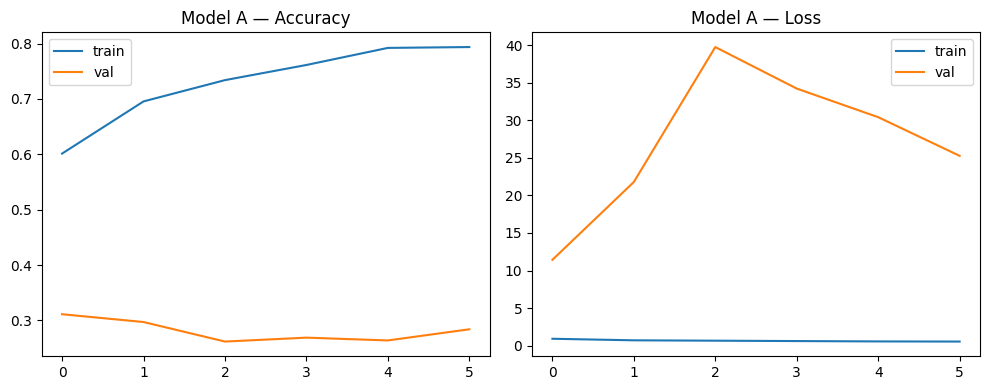

In [7]:
def plot_history(hist, title_prefix="Model A"):
    h = hist.history
    fig, axes = plt.subplots(1, 2, figsize=(10,4))

    axes[0].plot(h["accuracy"], label="train")
    axes[0].plot(h["val_accuracy"], label="val")
    axes[0].set_title(f"{title_prefix} — Accuracy"); axes[0].legend()

    axes[1].plot(h["loss"], label="train")
    axes[1].plot(h["val_loss"], label="val")
    axes[1].set_title(f"{title_prefix} — Loss"); axes[1].legend()

    plt.tight_layout()
    fig.savefig(os.path.join(FIG_DIR, "modelA_train_curves.png"), dpi=150)
    plt.show()

plot_history(history)


In [9]:
bestA = tf.keras.models.load_model(ckpt_path)

y_true, y_pred = [], []
for bx, by in test_prep:
    probs = bestA.predict(bx, verbose=0)
    y_pred.extend(np.argmax(probs, axis=1))
    y_true.extend(np.argmax(by.numpy(), axis=1))

# Classification report (includes precision, recall, F1)
reportA = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
print(classification_report(y_true, y_pred, target_names=class_names))

with open(os.path.join(MET_DIR, "modelA_classification_report.json"), "w") as f:
    json.dump(reportA, f, indent=2)


                       precision    recall  f1-score   support

Tomato_Bacterial_spot       0.00      0.00      0.00       320
  Tomato_Early_blight       0.00      0.00      0.00       150
   Tomato_Late_blight       0.50      0.24      0.33       287
       Tomato_healthy       0.28      1.00      0.44       240

             accuracy                           0.31       997
            macro avg       0.19      0.31      0.19       997
         weighted avg       0.21      0.31      0.20       997



C:\Users\Asus\miniconda3\envs\cv_partb\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Asus\miniconda3\envs\cv_partb\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Asus\miniconda3\envs\cv_partb\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

In [10]:
import numpy as np, collections

pred_counts = collections.Counter(y_pred)
print("Pred counts by index:", pred_counts)
print("Index→class mapping:", dict(enumerate(class_names)))


Pred counts by index: Counter({3: 856, 2: 141})
Index→class mapping: {0: 'Tomato_Bacterial_spot', 1: 'Tomato_Early_blight', 2: 'Tomato_Late_blight', 3: 'Tomato_healthy'}


In [11]:
import os, glob
from collections import Counter

train_counts = {}
for i, cls in enumerate(class_names):
    train_counts[cls] = len(glob.glob(os.path.join(DATA_DIR, "train", cls, "*")))

print("Train counts:", train_counts)

total = sum(train_counts.values())
class_weight = {}
for i, cls in enumerate(class_names):
    # Inverse-frequency weighting (simple & effective)
    class_weight[i] = total / (len(class_names) * train_counts[cls])

print("Class weights (idx→weight):", class_weight)


Train counts: {'Tomato_Bacterial_spot': 1488, 'Tomato_Early_blight': 700, 'Tomato_Late_blight': 1336, 'Tomato_healthy': 1113}
Class weights (idx→weight): {0: 0.7790658602150538, 1: 1.6560714285714286, 2: 0.8677020958083832, 3: 1.0415543575920934}


In [12]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers

def build_baseline_v2(input_shape=(224,224,3), num_classes=3):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same",
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same",
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.MaxPooling2D()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

modelA2 = build_baseline_v2(num_classes=num_classes)
modelA2.compile(optimizer=keras.optimizers.Adam(5e-4),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

ckpt_path_A2 = os.path.join(CKPT_DIR, "modelA_best_v2.keras")
callbacks_A2 = [
    keras.callbacks.ModelCheckpoint(ckpt_path_A2, monitor="val_accuracy",
                                    mode="max", save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max",
                                  patience=6, restore_best_weights=True)
]

history_A2 = modelA2.fit(
    train_prep,
    validation_data=val_prep,
    epochs=30,
    callbacks=callbacks_A2,
    class_weight=class_weight,
    verbose=1
)


Epoch 1/30
144/145 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3792 - loss: 1.2353

C:\Users\Asus\miniconda3\envs\cv_partb\lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from None to 0.26284, saving model to C:\cv_partb\outputs\checkpoints\modelA_best_v2.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.4708 - loss: 1.0810 - val_accuracy: 0.2628 - val_loss: 8.0876
Epoch 2/30
144/145 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6373 - loss: 0.8543
Epoch 2: val_accuracy did not improve from 0.26284
145/145 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.6508 - loss: 0.8324 - val_accuracy: 0.2457 - val_loss: 19.0836
Epoch 3/30
144/145 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6800 - loss: 0.7846
Epoch 3: val_accuracy did not improve from 0.26284
145/145 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.6843 - loss: 0.7738 - val_accuracy: 0.2437 - val_loss: 24.9992
Epoch 4/30
144/145 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6881 - loss: 0.7427
Epoch 4: val_accuracy did not improve from 0.26284
145/145 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.6932 - loss: 0.7410 - val_accuracy: 0.2447 - val_loss: 35

C:\Users\Asus\miniconda3\envs\cv_partb\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Asus\miniconda3\envs\cv_partb\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Asus\miniconda3\envs\cv_partb\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

                       precision    recall  f1-score   support

Tomato_Bacterial_spot       0.00      0.00      0.00       320
  Tomato_Early_blight       0.00      0.00      0.00       150
   Tomato_Late_blight       0.71      0.05      0.10       287
       Tomato_healthy       0.25      1.00      0.39       240

             accuracy                           0.26       997
            macro avg       0.24      0.26      0.12       997
         weighted avg       0.26      0.26      0.12       997



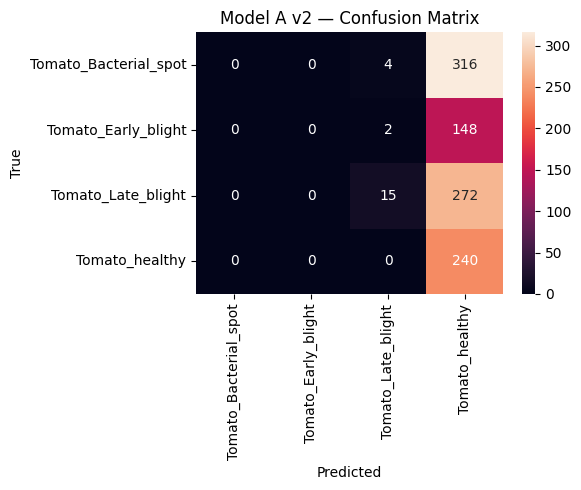

In [13]:
bestA2 = tf.keras.models.load_model(ckpt_path_A2)

y_true2, y_pred2 = [], []
for bx, by in test_prep:
    pp = bestA2.predict(bx, verbose=0)
    y_pred2.extend(np.argmax(pp, axis=1))
    y_true2.extend(np.argmax(by.numpy(), axis=1))

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true2, y_pred2, target_names=class_names))

cmA2 = confusion_matrix(y_true2, y_pred2)
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cmA2, annot=True, fmt="d",
            xticklabels=class_names, yticklabels=class_names, ax=ax)
ax.set_title("Model A v2 — Confusion Matrix"); ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.tight_layout(); plt.show()
